In [25]:
import pull_optionm_api_data as pull_optionm
import clean_bloomberg as clean_bbg
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from settings import config


$$
1 + f_{t}^{\pi, \tau_2}
= \frac{1 + r_{t}^{f}\,\tau_2}{1 + r_{t}^{f}\,\tau_1}
= \frac{F_{t,\tau_2} + \mathbb{E}_{t}^{Q}[D_{t,\tau_2}]}{F_{t,\tau_1} + \mathbb{E}_{t}^{Q}[D_{t,\tau_1}]}
$$

As can be seen above, we need futures close data for the two closest maturity and the expected dividend yield as well.
Expected dividend yield can be approximated with implied dividend yield as this is the market expectation embedded in index option.

STEP1 Implied Dividend yield from index options data 

Loading library list...
Done

📌 DataFrame Info for SPX:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102536 entries, 0 to 102535
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   secid           102536 non-null  float64       
 1   date            102536 non-null  datetime64[ns]
 2   cusip           102536 non-null  object        
 3   ticker          102536 non-null  object        
 4   sic             102536 non-null  object        
 5   index_flag      102536 non-null  object        
 6   exchange_d      102536 non-null  float64       
 7   class           0 non-null       object        
 8   issue_type      102536 non-null  object        
 9   industry_group  0 non-null       object        
 10  expiration      102536 non-null  object        
 11  rate            102536 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 9.4+ MB
None

📊 First 5 Rows

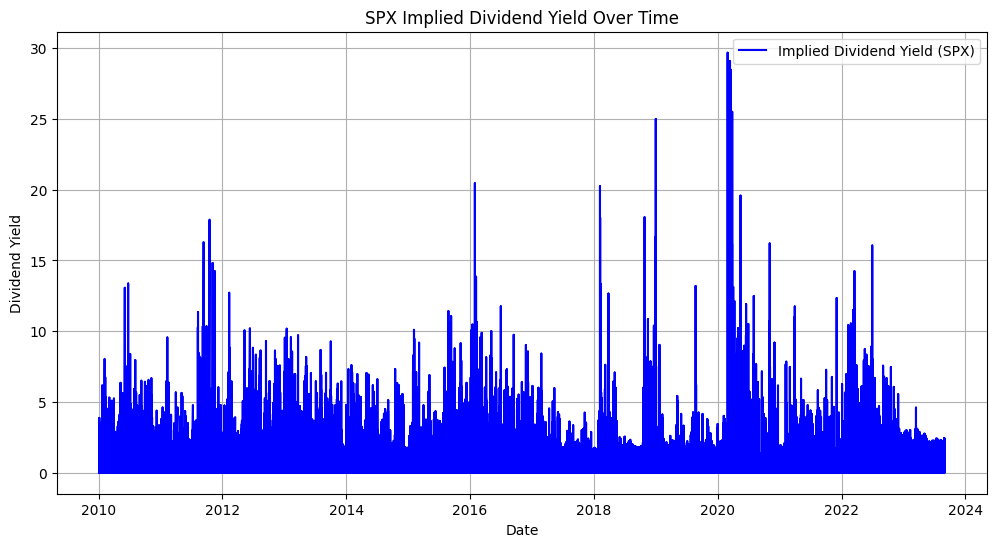

In [8]:
spx_div = pull_optionm.pull_index_implied_dividend_yield('SPX')

In [20]:
spx_div.head()

,secid,date,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,expiration,rate
0,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-01-08,0.000000
1,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-01-16,3.583896
2,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-02-20,2.628215
3,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-20,2.271277
4,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-31,2.179555


Since we only need index dividend yield for nearest and deferred month contract, filter only those expiration dates

In [10]:
spx_div_filtered= pull_optionm.filter_index_implied_dividend_yield(spx_div)
spx_div_filtered.head()

current_date: 2010-03-19 00:00:00, 
current_date: 2010-06-18 00:00:00, 
current_date: 2010-09-17 00:00:00, 
current_date: 2010-12-17 00:00:00, 
current_date: 2011-03-18 00:00:00, 
current_date: 2011-06-17 00:00:00, 
current_date: 2011-09-16 00:00:00, 
current_date: 2011-12-16 00:00:00, 
current_date: 2012-03-16 00:00:00, 
current_date: 2012-06-15 00:00:00, 
current_date: 2012-09-21 00:00:00, 
current_date: 2012-12-21 00:00:00, 
current_date: 2013-03-15 00:00:00, 
current_date: 2013-06-21 00:00:00, 
current_date: 2013-09-20 00:00:00, 
current_date: 2013-12-20 00:00:00, 
current_date: 2014-03-21 00:00:00, 
current_date: 2014-06-20 00:00:00, 
current_date: 2014-09-19 00:00:00, 
current_date: 2014-12-19 00:00:00, 
current_date: 2015-03-20 00:00:00, 
current_date: 2015-06-19 00:00:00, 
current_date: 2015-09-18 00:00:00, 
current_date: 2015-12-18 00:00:00, 
current_date: 2016-03-18 00:00:00, 
current_date: 2016-06-17 00:00:00, 
current_date: 2016-09-16 00:00:00, 
current_date: 2016-12-16 00:

,secid,date,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,expiration,rate
3,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.271277
6,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-06-18,2.165414
18,108105.0,2010-01-05,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.325091
21,108105.0,2010-01-05,64881510,SPX,9999,1,32768.0,None,A,None,2010-06-18,2.193982
33,108105.0,2010-01-06,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.154393


We pull futures price data from the bloomberg thus, we need to clean this data as well

Note that start date is before our scope of analysis.
The reason for this is because when given a target date it looks for in which range of expiration is in between and then returns the one with nearest expiry and the deferred contract. But this logic can be improved.
Moreover, even though ES1, ES2 is the first two contracts with closest expiry the reason why need ES3 is that on expiration date, we need to roll over to the next contract

STEP2 Futures close data for each index

In [21]:
df_raw = pd.read_parquet('../data_manual/bloomberg_historical_data.parquet') # can be automated as well

start_date = datetime.strftime(config("START_DATE").date()-relativedelta(years=1),format="%Y-%m-%d") 
end_date = datetime.strftime(config("END_DATE"),format="%Y-%m-%d")

expiration_months = [3, 6, 9, 12]
expiration_dates = pull_optionm.get_expiration_dates(start_date, end_date, expiration_months)

# near future expiration date and far future expiration date for each dates
date_ranges = [(start.date(), end.date()) for start, end in zip(expiration_dates, expiration_dates[1:])]

spx = ['ES1 Index','ES2 Index','ES3 Index']
spx_pairs= list(zip(spx,spx[1:]))

index_future_spx = clean_bbg.get_clean_df (df_raw, date_ranges, spx_pairs)
index_future_spx.head()

current_date: 2009-03-20 00:00:00, 
current_date: 2009-06-19 00:00:00, 
current_date: 2009-09-18 00:00:00, 
current_date: 2009-12-18 00:00:00, 
current_date: 2010-03-19 00:00:00, 
current_date: 2010-06-18 00:00:00, 
current_date: 2010-09-17 00:00:00, 
current_date: 2010-12-17 00:00:00, 
current_date: 2011-03-18 00:00:00, 
current_date: 2011-06-17 00:00:00, 
current_date: 2011-09-16 00:00:00, 
current_date: 2011-12-16 00:00:00, 
current_date: 2012-03-16 00:00:00, 
current_date: 2012-06-15 00:00:00, 
current_date: 2012-09-21 00:00:00, 
current_date: 2012-12-21 00:00:00, 
current_date: 2013-03-15 00:00:00, 
current_date: 2013-06-21 00:00:00, 
current_date: 2013-09-20 00:00:00, 
current_date: 2013-12-20 00:00:00, 
current_date: 2014-03-21 00:00:00, 
current_date: 2014-06-20 00:00:00, 
current_date: 2014-09-19 00:00:00, 
current_date: 2014-12-19 00:00:00, 
current_date: 2015-03-20 00:00:00, 
current_date: 2015-06-19 00:00:00, 
current_date: 2015-09-18 00:00:00, 
current_date: 2015-12-18 00:

,Near Month PX_LAST,Deferred Month PX_LAST
2010-01-04,1128.75,1124.00
2010-01-05,1132.25,1127.50
2010-01-06,1133.00,1128.00
2010-01-07,1137.50,1132.50
2010-01-08,1141.50,1136.75


STEP3 Convert dividend yield to a index level

See below again at column rate, we need to multiply index level to convert the rate into a index level.
Also preferably, it is easier to calculate further stuffs if we make each of the expiration have different columns

In [22]:
spx_div_filtered.head()

,secid,date,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,expiration,rate
3,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.271277
6,108105.0,2010-01-04,64881510,SPX,9999,1,32768.0,None,A,None,2010-06-18,2.165414
18,108105.0,2010-01-05,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.325091
21,108105.0,2010-01-05,64881510,SPX,9999,1,32768.0,None,A,None,2010-06-18,2.193982
33,108105.0,2010-01-06,64881510,SPX,9999,1,32768.0,None,A,None,2010-03-19,2.154393


In [26]:
index_pairs_map = {
    "SPX": spx_pairs
}

index_optionm_df= dict()
index_future_df= dict()
index_df= dict()

In [27]:
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")

Loading library list...
Done

📌 DataFrame Info for SPX:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102536 entries, 0 to 102535
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   secid           102536 non-null  float64       
 1   date            102536 non-null  datetime64[ns]
 2   cusip           102536 non-null  object        
 3   ticker          102536 non-null  object        
 4   sic             102536 non-null  object        
 5   index_flag      102536 non-null  object        
 6   exchange_d      102536 non-null  float64       
 7   class           0 non-null       object        
 8   issue_type      102536 non-null  object        
 9   industry_group  0 non-null       object        
 10  expiration      102536 non-null  object        
 11  rate            102536 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 9.4+ MB
None

📊 First 5 Rows

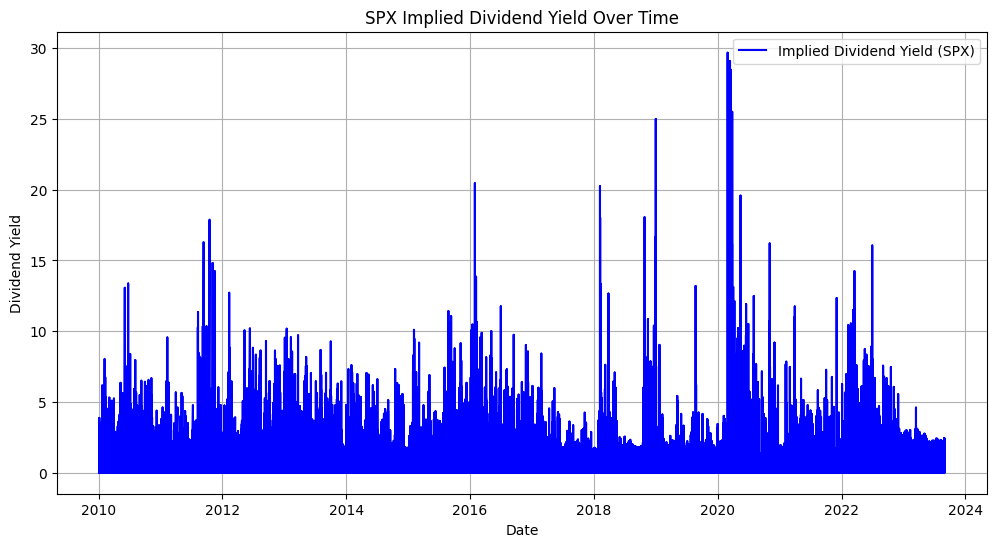


📌 Loaded DataFrame Info for SPX:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102536 entries, 0 to 102535
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   secid           102536 non-null  float64       
 1   date            102536 non-null  datetime64[ns]
 2   cusip           102536 non-null  object        
 3   ticker          102536 non-null  object        
 4   sic             102536 non-null  object        
 5   index_flag      102536 non-null  object        
 6   exchange_d      102536 non-null  float64       
 7   class           0 non-null       object        
 8   issue_type      102536 non-null  object        
 9   industry_group  0 non-null       object        
 10  expiration      102536 non-null  object        
 11  rate            102536 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 9.4+ MB
None

📊 First 5 Rows for SPX (Loaded from 

In [28]:
df_div_yield = pull_optionm.pull_index_implied_dividend_yield(
        "SPX", start_date=START_DATE, end_date=END_DATE
    )

df_loaded = pull_optionm.load_index_implied_dividend_yield("SPX")

df_filtered = pull_optionm.filter_index_implied_dividend_yield(df_loaded)
df_filtered = df_filtered.sort_values(by=['date','expiration']).groupby('date').agg(list)
df_filtered[['expiration_near','expiration_next']] = pd.DataFrame(df_filtered['expiration'].tolist(), index=df_filtered.index)
df_filtered[['rate_near','rate_next']] = pd.DataFrame(df_filtered['rate'].tolist(), index=df_filtered.index)
df_filtered = df_filtered.drop(columns=['expiration','rate'])
df_filtered = df_filtered.filter(items=['date','expiration_near','expiration_next','rate_near','rate_next'])
df_filtered.index = [ts.date() for ts in df_filtered.index]


In [29]:
df_filtered

,expiration_near,expiration_next,rate_near,rate_next
2010-01-04,2010-03-19,2010-06-18,2.271277,2.165414
2010-01-05,2010-03-19,2010-06-18,2.325091,2.193982
2010-01-06,2010-03-19,2010-06-18,2.154393,2.091007
2010-01-07,2010-03-19,2010-06-18,1.956856,2.003116
2010-01-08,2010-03-19,2010-06-18,2.183158,2.053604
...,...,...,...,...
2023-08-25,2023-09-15,2023-12-15,0.415157,0.933514
2023-08-28,2023-09-15,2023-12-15,0.053723,0.734384
2023-08-29,2023-09-15,2023-12-15,0.213914,0.879674
2023-08-30,2023-09-15,2023-12-15,0.082968,0.796566


In [30]:
index_optionm_df["SPX"] = df_filtered

index_future_df["SPX"] = clean_bbg.get_clean_df(df_raw, date_ranges, index_pairs_map["SPX"]) 

index_df["SPX"] = df_raw["SPX" + " Index"]
index_df["SPX"].dropna(inplace=True)

rolled over
2010-03-19 (datetime.date(2010, 3, 19), datetime.date(2010, 6, 18)) (datetime.date(2010, 6, 18), datetime.date(2010, 9, 17))
rolled over
2010-06-18 (datetime.date(2010, 6, 18), datetime.date(2010, 9, 17)) (datetime.date(2010, 9, 17), datetime.date(2010, 12, 17))
rolled over
2010-09-17 (datetime.date(2010, 9, 17), datetime.date(2010, 12, 17)) (datetime.date(2010, 12, 17), datetime.date(2011, 3, 18))
rolled over
2010-12-17 (datetime.date(2010, 12, 17), datetime.date(2011, 3, 18)) (datetime.date(2011, 3, 18), datetime.date(2011, 6, 17))
rolled over
2011-03-18 (datetime.date(2011, 3, 18), datetime.date(2011, 6, 17)) (datetime.date(2011, 6, 17), datetime.date(2011, 9, 16))
rolled over
2011-06-17 (datetime.date(2011, 6, 17), datetime.date(2011, 9, 16)) (datetime.date(2011, 9, 16), datetime.date(2011, 12, 16))
rolled over
2011-09-16 (datetime.date(2011, 9, 16), datetime.date(2011, 12, 16)) (datetime.date(2011, 12, 16), datetime.date(2012, 3, 16))
rolled over
2011-12-16 (datetime.d

C:\Users\moose\AppData\Local\Temp\ipykernel_23136\43929959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_df["SPX"].dropna(inplace=True)


In [31]:
index_df['SPX'].head()

,PX_LAST,IDX_EST_DVD_YLD,INDX_GROSS_DAILY_DIV
2010-01-04,1132.98,1.9966,0.058362
2010-01-05,1136.52,1.9903,0.001744
2010-01-06,1137.14,1.9891,0.497980
2010-01-07,1141.70,1.9808,0.061819
2010-01-08,1144.98,1.9753,0.000000


In [32]:
index_future_df['SPX'].head()

,Near Month PX_LAST,Deferred Month PX_LAST
2010-01-04,1128.75,1124.00
2010-01-05,1132.25,1127.50
2010-01-06,1133.00,1128.00
2010-01-07,1137.50,1132.50
2010-01-08,1141.50,1136.75


In [33]:
index_optionm_df['SPX'].head()

,expiration_near,expiration_next,rate_near,rate_next
2010-01-04,2010-03-19,2010-06-18,2.271277,2.165414
2010-01-05,2010-03-19,2010-06-18,2.325091,2.193982
2010-01-06,2010-03-19,2010-06-18,2.154393,2.091007
2010-01-07,2010-03-19,2010-06-18,1.956856,2.003116
2010-01-08,2010-03-19,2010-06-18,2.183158,2.053604


However, note that implied dividend yield is annualized thus, we need to take time to maturity into account

In [34]:
index_optionm_df["SPX"][['days_to_near_expiry','days_to_far_expiry']] = index_optionm_df["SPX"][['expiration_near','expiration_next']].apply(lambda x: x - index_optionm_df["SPX"].index)
index_optionm_df["SPX"][['days_to_near_expiry','days_to_far_expiry']] = index_optionm_df["SPX"][['days_to_near_expiry','days_to_far_expiry']].applymap(lambda x: x.days)/360
index_optionm_df["SPX"][['div_near','div_next']] = index_optionm_df["SPX"][['rate_near','rate_next']] .apply(lambda x: x *index_df["SPX"]['PX_LAST'])/100
index_optionm_df["SPX"][['div_near', 'div_next']] = (
index_optionm_df["SPX"][['div_near', 'div_next']].values *
index_optionm_df["SPX"][['days_to_near_expiry', 'days_to_far_expiry']].values)

C:\Users\moose\AppData\Local\Temp\ipykernel_23136\3317625546.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  index_optionm_df["SPX"][['days_to_near_expiry','days_to_far_expiry']] = index_optionm_df["SPX"][['days_to_near_expiry','days_to_far_expiry']].applymap(lambda x: x.days)/360


In [35]:
index_optionm_df["SPX"]

,expiration_near,expiration_next,rate_near,rate_next,days_to_near_expiry,days_to_far_expiry,div_near,div_next
2010-01-04,2010-03-19,2010-06-18,2.271277,2.165414,0.205556,0.458333,5.289585,11.244616
2010-01-05,2010-03-19,2010-06-18,2.325091,2.193982,0.202778,0.455556,5.358428,11.359298
2010-01-06,2010-03-19,2010-06-18,2.154393,2.091007,0.200000,0.452778,4.899693,10.766004
2010-01-07,2010-03-19,2010-06-18,1.956856,2.003116,0.197222,0.450000,4.406225,10.291309
2010-01-08,2010-03-19,2010-06-18,2.183158,2.053604,0.194444,0.447222,4.860474,10.515695
...,...,...,...,...,...,...,...,...
2023-08-25,2023-09-15,2023-12-15,0.415157,0.933514,0.058333,0.311111,1.066952,12.795353
2023-08-28,2023-09-15,2023-12-15,0.053723,0.734384,0.050000,0.302778,0.119085,9.857693
2023-08-29,2023-09-15,2023-12-15,0.213914,0.879674,0.047222,0.300000,0.454328,11.869345
2023-08-30,2023-09-15,2023-12-15,0.082968,0.796566,0.044444,0.297222,0.166484,10.689276


STEP4 Annualizing and rescaling

Forward rate calculated with the formula I mentioned above is not annualized. We have to annualize it by a scale of inverse of remaining maturity
Likewise, we also calculate implied forward rates on OIS rate to compare it with forward rate embedded in futures.
Think it this way, if implied forward rate in futures > implied OIS 3M, you can enter short OIS3M ( pay fixed get float) and enter calendar spread. From calendar spread you will get fixed +alpha thus can earn float+alpha for t,tau1


In [37]:
implied_forward_df = dict()
implied_forward_df["SPX"] = pd.DataFrame(index=index_future_df["SPX"].index, columns=['Implied Forward','Near Month TTM','Deferred Month TTM','Annualised'])
implied_forward_df["SPX"]['Implied Forward'] = (((index_future_df["SPX"]['Deferred Month PX_LAST']+index_optionm_df["SPX"]['div_next']) \
    /(index_future_df["SPX"]['Near Month PX_LAST']+index_optionm_df["SPX"]['div_near']))-1)*100
implied_forward_df["SPX"]['Near Month TTM'] = index_optionm_df["SPX"]['days_to_near_expiry']
implied_forward_df["SPX"]['Deferred Month TTM'] = index_optionm_df["SPX"]['days_to_far_expiry']
implied_forward_df["SPX"]['Annualised'] = (implied_forward_df["SPX"]['Implied Forward']) / (implied_forward_df["SPX"]['Deferred Month TTM'] - implied_forward_df["SPX"]['Near Month TTM']) 


In [38]:

ois_df = df_raw['USSOC CMPN Curncy']['PX_LAST']
ois_df.dropna(inplace=True)

implied_forward_df['OIS'] = pd.DataFrame(index=ois_df.index, columns=['Annualised'])
implied_forward_df['OIS']['Annualised'] = ((1+ois_df/100 * implied_forward_df['SPX']['Deferred Month TTM'])/(1+ois_df/100 * implied_forward_df['SPX']['Near Month TTM'])-1)*4*100


C:\Users\moose\AppData\Local\Temp\ipykernel_23136\3636559970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df.dropna(inplace=True)


In [49]:
import matplotlib.pyplot as plt


total_df = pd.concat([implied_forward_df['SPX']['Annualised']

    ,implied_forward_df['OIS']],axis=1)
total_df.columns = ['SPX','OIS']
total_df.dropna(inplace=True)

total_df['SPX_Spread'] = total_df['SPX'] -total_df['OIS']
total_df['SPX_Spread'] *= 100



Final step. Plotting the spread


[*********************100%***********************]  1 of 1 completed


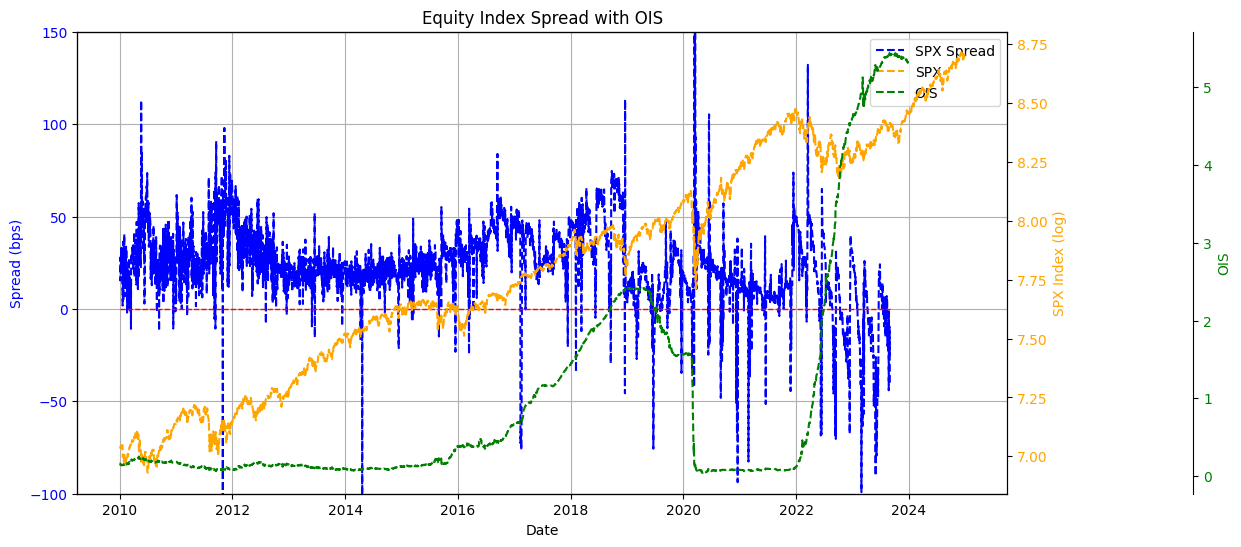

In [58]:
import yfinance as yf



sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE)

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(total_df.index, total_df['SPX_Spread'],
         label='SPX Spread', linestyle='--', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread (bps)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.hlines(0, total_df.index[0], total_df.index[-1],
           color='red', linestyles='--', linewidth=1)
ax1.set_ylim(-100, 150)

ax2 = ax1.twinx()
ax2.plot(sp500.index, np.log(sp500['Close']),
         label='SPX', linestyle='--', color='orange')
ax2.set_ylabel('SPX Index (log)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


ax3 = ax1.twinx()

ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(ois_df.index, ois_df.values,  
         label='OIS', linestyle='--', color='green')
ax3.set_ylabel('OIS', color='green')
ax3.tick_params(axis='y', labelcolor='green')


plt.title('Equity Index Spread with OIS')
ax1.grid(True)


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='best')

plt.show()
